In [5]:
from paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform


In [7]:
import mxnet as mx

In [8]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()


Paragraph cropped and saved at cropped_paragraph.png


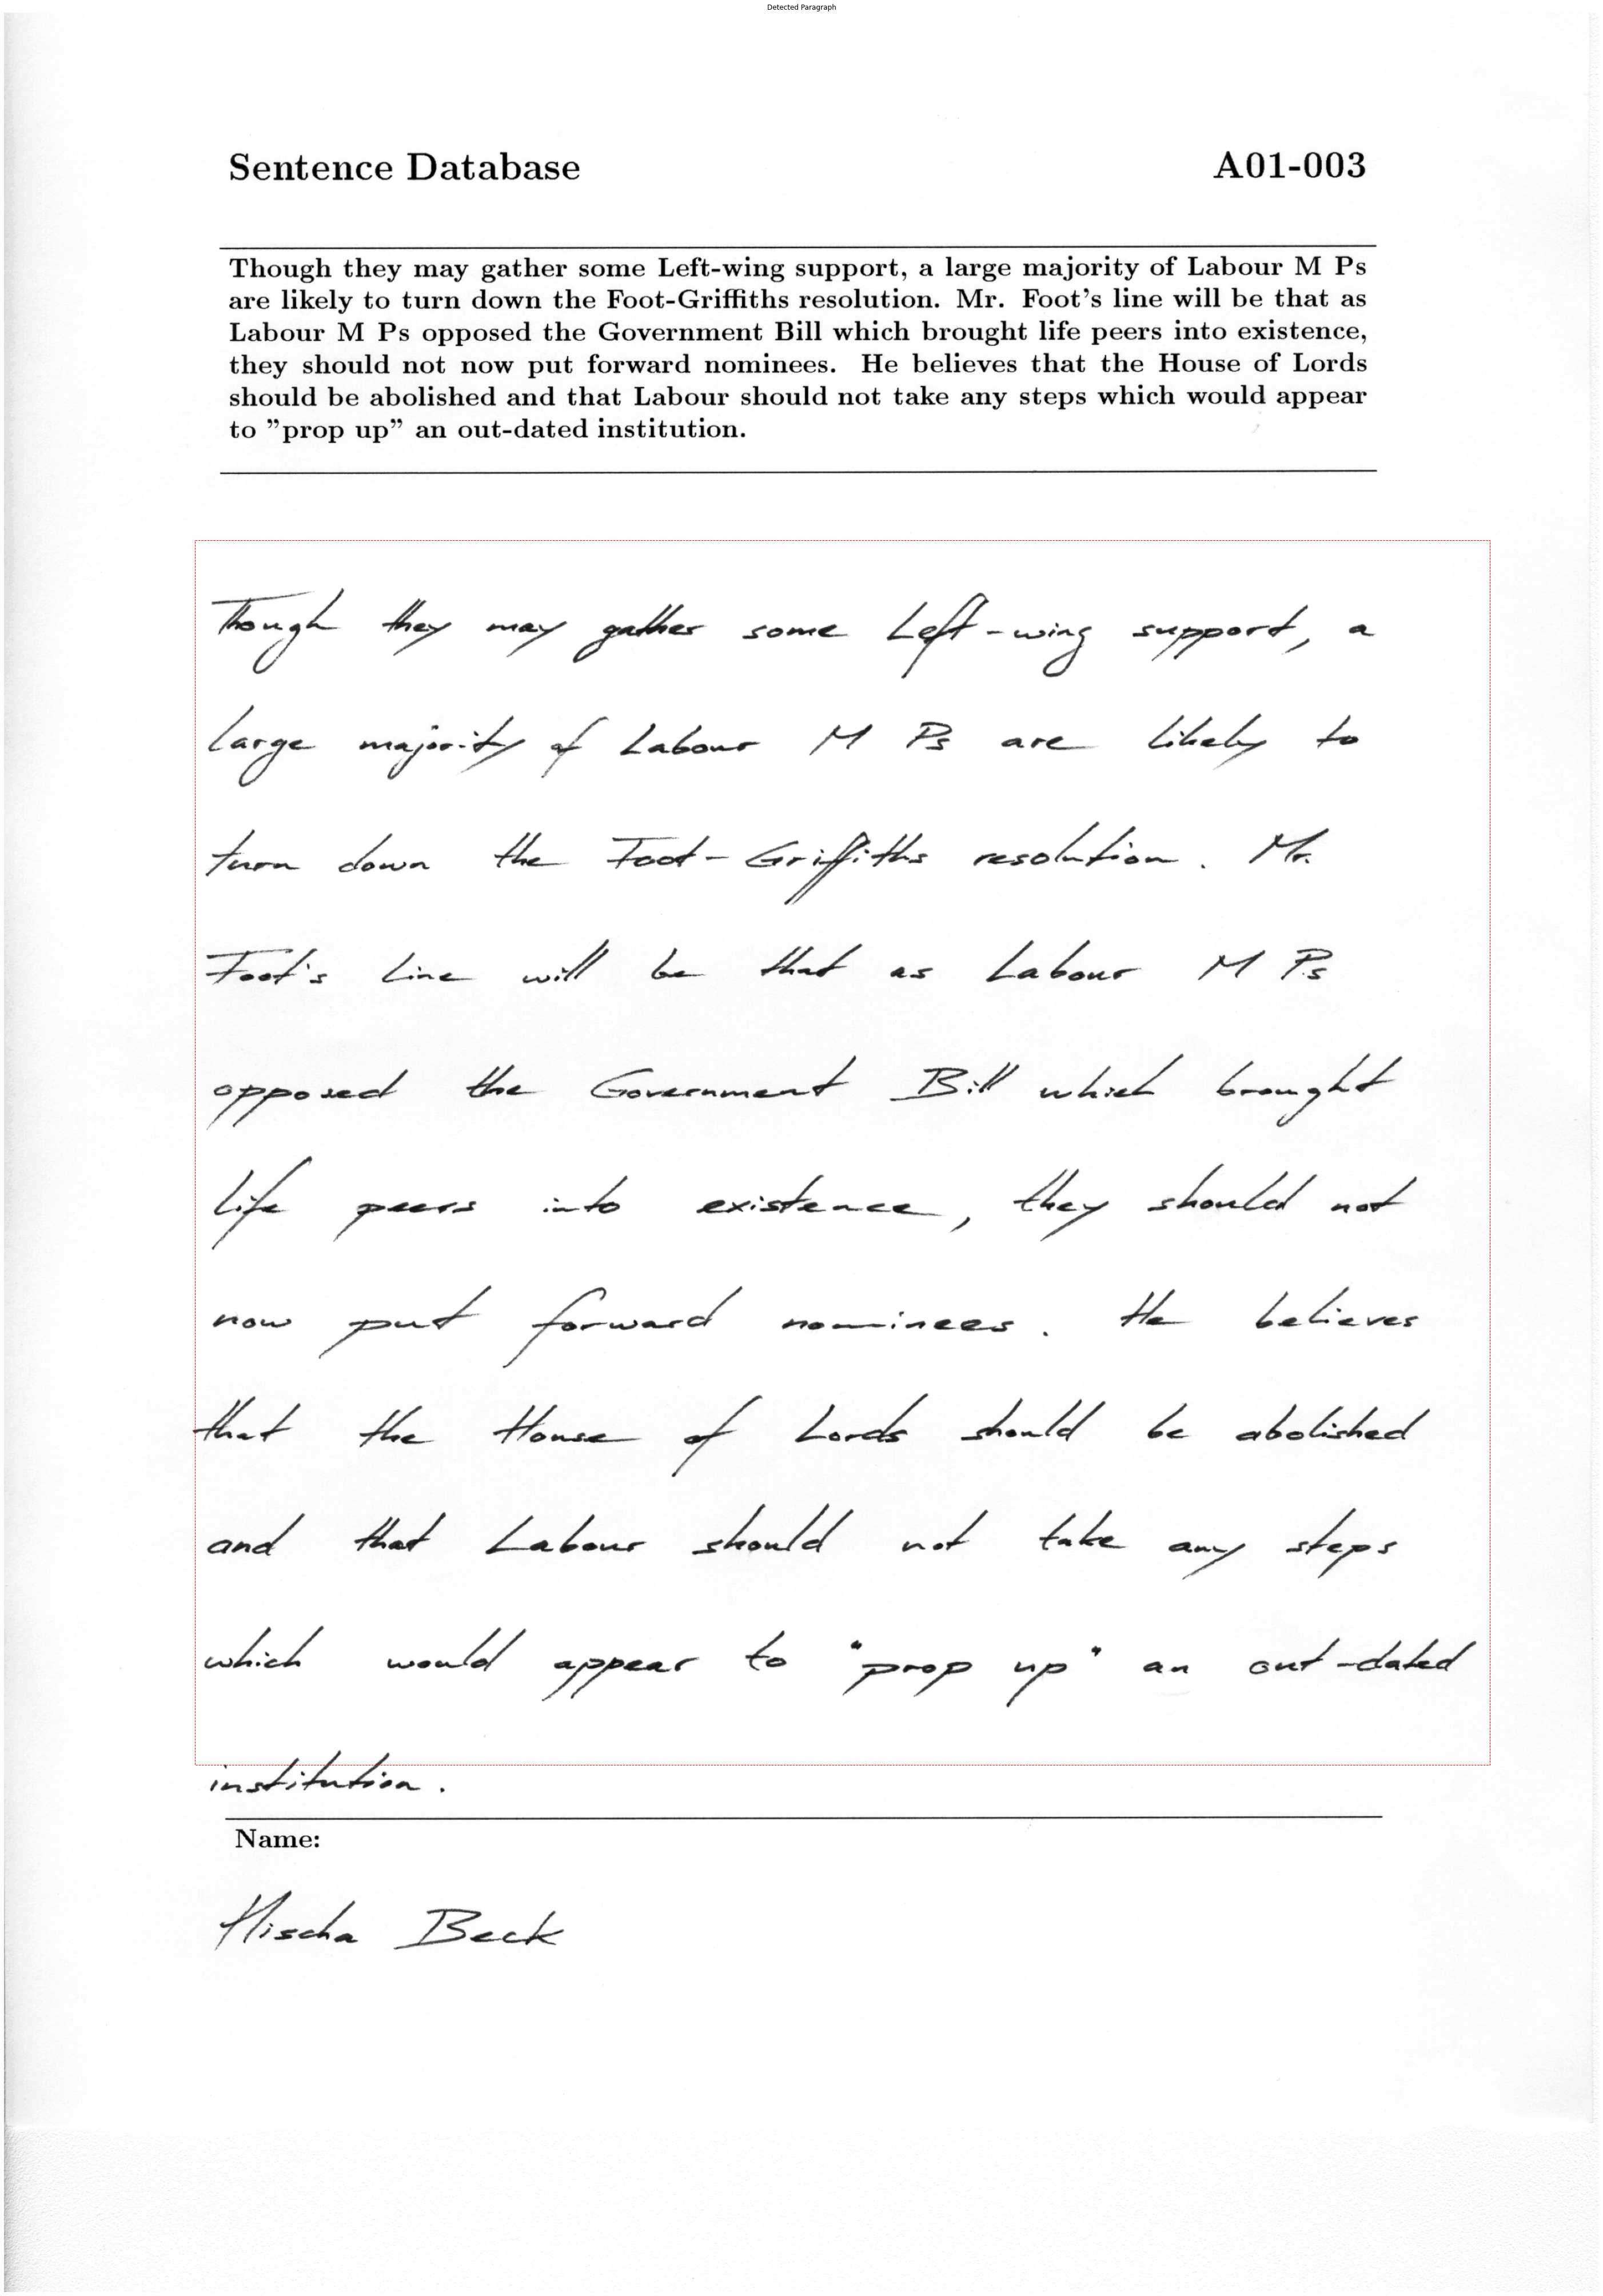

In [47]:
import cv2
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mxnet import nd
from paragraph_segmentation_dcnn import paragraph_segmentation_transform
from utils.expand_bounding_box import expand_bounding_box
from utils.iam_dataset import resize_image

# Step 1: Load and initialize the paragraph segmentation model
ctx = mx.cpu()  # Change to mx.gpu() if you are using a GPU
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
paragraph_segmentation_net.cnn.load_parameters("models/paragraph_segmentation2.params", ctx=ctx)
paragraph_segmentation_net.hybridize()

# Step 2: Define the form size and image loading
image_path = 'formsA-D/a01-003.png'

#image_path = 'formsA-D/a01-007.png'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
form_size = (1120, 800)

# Step 3: Resize the image for the segmentation network
resized_image = paragraph_segmentation_transform(image, form_size)

# Step 4: Ensure the image has the shape (batch_size, channels, height, width)
if resized_image.ndim == 3:  # If the image is 3D (channels, height, width), add a batch dimension
    resized_image_nd = nd.array(resized_image).expand_dims(axis=0).as_in_context(ctx)
elif resized_image.ndim == 4:  # If it's already 4D, just convert it to MXNet array
    resized_image_nd = nd.array(resized_image).as_in_context(ctx)

# Step 5: Predict the bounding box
bb_predicted = paragraph_segmentation_net(resized_image_nd)[0].asnumpy()

# Step 6: Expand the bounding box (optional step for scaling)
bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03, expand_bb_scale_y=0.03)

# Step 7: Scale the bounding box back to the original image size
image_h, image_w = image.shape[-2:]  # Original image height and width
x, y, w, h = bb_predicted  # Unpack bounding box (relative to resized image)
x = x * image_w
y = y * image_h
w = w * image_w
h = h * image_h

# Step 8: Crop the original image based on the bounding box
xmin, ymin, xmax, ymax = int(x), int(y), int(x + w), int(y + h)
cropped_paragraph = image[ymin:ymax, xmin:xmax]

# Step 9: Save the cropped paragraph as a new image
output_path = 'cropped_paragraph.png'
cv2.imwrite(output_path, cropped_paragraph)
print(f"Paragraph cropped and saved at {output_path}")

# Step 10: Visualization with bounding box for debugging
fig, ax = plt.subplots(1, figsize=(50, 300))
ax.imshow(image, cmap='Greys_r')
rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
ax.add_patch(rect)
ax.set_title("Detected Paragraph")
ax.axis('off')
plt.show()


In [48]:
import cv2
import mxnet as mx
import numpy as np
import os
from mxnet import nd
from tqdm import tqdm  # For progress bar
from paragraph_segmentation_dcnn import paragraph_segmentation_transform
from utils.expand_bounding_box import expand_bounding_box
from utils.iam_dataset import resize_image

# Step 1: Load and initialize the paragraph segmentation model
ctx = mx.cpu()  # Change to mx.gpu() if you are using a GPU
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
paragraph_segmentation_net.cnn.load_parameters("models/paragraph_segmentation2.params", ctx=ctx)
paragraph_segmentation_net.hybridize()

# Step 2: Define input and output directories
input_dir = r'C:\Users\diego\IAM\formsI-Z'
output_dir = r'C:\Users\diego\IAM\post_formsI-Z'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Step 3: Loop through all files in the input directory
form_size = (1120, 800)
for file_name in tqdm(os.listdir(input_dir), desc="Processing files"):
    if file_name.endswith('.png'):  # Process only PNG files
        image_path = os.path.join(input_dir, file_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Step 4: Resize the image for the segmentation network
        resized_image = paragraph_segmentation_transform(image, form_size)

        # Ensure the image has the shape (batch_size, channels, height, width)
        if resized_image.ndim == 3:  # If the image is 3D (channels, height, width), add a batch dimension
            resized_image_nd = nd.array(resized_image).expand_dims(axis=0).as_in_context(ctx)
        elif resized_image.ndim == 4:  # If it's already 4D, just convert it to MXNet array
            resized_image_nd = nd.array(resized_image).as_in_context(ctx)

        # Step 5: Predict the bounding box
        bb_predicted = paragraph_segmentation_net(resized_image_nd)[0].asnumpy()

        # Step 6: Expand the bounding box
        bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03, expand_bb_scale_y=0.03)

        # Step 7: Scale the bounding box back to the original image size
        image_h, image_w = image.shape[-2:]  # Original image height and width
        x, y, w, h = bb_predicted  # Unpack bounding box (relative to resized image)
        x = x * image_w
        y = y * image_h
        w = w * image_w
        h = h * image_h

        # Step 8: Crop the original image based on the bounding box
        xmin, ymin, xmax, ymax = int(x), int(y), int(x + w), int(y + h)
        cropped_paragraph = image[ymin:ymax, xmin:xmax]

        # Step 9: Save the cropped paragraph as a new image in the output directory
        output_path = os.path.join(output_dir, file_name)
        cv2.imwrite(output_path, cropped_paragraph)

print(f"All images processed and saved in {output_dir}")


Processing files: 100%|██████████| 488/488 [02:02<00:00,  3.98it/s]

All images processed and saved in C:\Users\diego\IAM\post_formsI-Z
